In [77]:
"""
Genetic algorithm to pilot a car on a circuit made of several check points:
- you can rotate the car between -20 and 20 degrees
- you can thrust between 0 and 100 (percentage)
- you cannot break for now

Interesting resources:
* http://files.magusgeek.com/csb/csb_en.html
* https://www.codingame.com/blog/genetic-algorithms-coders-strike-back-game/?utm_source=codingame&utm_medium=details-page&utm_campaign=cg-blog&utm_content=csb
* https://www.codingame.com/blog/evolutionary-trajectory-optimization/?utm_source=codingame&utm_medium=details-page&utm_campaign=cg-blog&utm_content=csb
* https://www.codingame.com/multiplayer/bot-programming/coders-strike-back
* https://en.wikipedia.org/wiki/Multi-agent_system

TODO - try other approaches like:
- neural nets (regression problem): but where do you get the data? CHECK https://www.docdroid.net/NgvoYFR/csb-nn-slides.pdf
- RL (and there you might be able to use neural nets)
"""

import abc
from collections import *
import copy
from dataclasses import *
import math
import numpy as np
from typing import *

%matplotlib inline
import imageio
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy
from PIL import Image

In [171]:
Vector = np.ndarray

Angle = float
Distance = float
Duration = float
Mass = float
Speed = float

AngularSpeed = float
Thrust = float


@dataclass(frozen=True)
class Action:
    turn: AngularSpeed
    thrust: Thrust


@dataclass(frozen=True)
class Vehicle:
    mass: Mass
    position: Vector
    speed: Speed
    direction: Angle

        
@dataclass(frozen=True)
class CheckPoint:
    position: Vector
    radius: Distance
        

def get_angle(vector):
    # Get angle from a vector (x, y)
    x, y = vector
    if x > 0: return np.arctan(y / x)
    if x < 0: return np.arctan(y / x) + (math.pi if y >= 0 else -math.pi)
    return math.pi / 2 if y >= 0 else -math.pi / 2


def norm(vector):
    return math.sqrt(np.dot(vector, vector))


def distance(x, y):
    return norm(x - y)


def constrain_between(value, low, high):
    if value < low:
        return low
    if value > high:
        return high
    return value

        
def move(vehicle: Vehicle, action: Action, time_step: Duration) -> Vehicle:
    """
    The formula is deduced from F = m * a = thrust
    => dv / dt = thrust / m
    => v(t+dt) = v(t) + thrust / m * dt
    """        
    turn = constrain_between(action.turn, - math.pi / 8, math.pi / 8)
    new_direction = (vehicle.direction + turn * time_step) % (2 * math.pi)
    
    # Compute the acceleration
    dv_dt = np.array([
        action.thrust * math.cos(new_direction) / vehicle.mass,
        action.thrust * math.sin(new_direction) / vehicle.mass
    ])
    
    # Compute the speed
    speed = np.array([
        vehicle.speed * math.cos(vehicle.direction),
        vehicle.speed * math.sin(vehicle.direction)
    ])
    
    # Update speed and position (include a friction force of 15%)
    new_speed = speed * 0.85 + dv_dt * time_step
    new_pos = vehicle.position + new_speed * time_step
    speed_norm = math.sqrt(np.dot(new_speed, new_speed))
    return Vehicle(mass=vehicle.mass, position=new_pos, speed=speed_norm, direction=new_direction)  


class Track:
    def __init__(self,
                 checkpoints: List[CheckPoint],
                 vehicle: Vehicle,
                 time_step: Duration):
        self.checkpoints = list(checkpoints)
        self.next_checkpoint_index = 0
        self.vehicle = vehicle
        self.time_step = time_step
    
    def is_over(self) -> bool:
        return self.next_checkpoint_index >= len(self.checkpoints)
    
    def get_vehicle(self) -> Vehicle:
        return self.vehicle
    
    def get_remaining_checkpoints(self) -> List[CheckPoint]:
        return self.checkpoints[self.next_checkpoint_index:]
    
    def move(self, action: Action) -> bool:
        self.vehicle = move(self.vehicle, action, self.time_step)
        checkpoint = self.checkpoints[self.next_checkpoint_index]
        if distance(self.vehicle.position, checkpoint.position) < checkpoint.radius:
            self.next_checkpoint_index += 1
        return self.is_over()
    
    def simulate(self, agent, max_duration: Duration) -> List[Vehicle]:
        duration = Duration()
        positions = []
        while duration < max_duration and not self.is_over():
            positions.append(self.get_vehicle())
            self.move(agent(self))
            duration += self.time_step
        return positions

        
class Agent(abc.ABC):
    @abc.abstractmethod
    def __call__(self, track: Track) -> Action:
        pass

    
class RenderedSimulation:
    # TODO - make it more beautiful
    
    def __init__(self, width: int, height: int, scale: float):
        self.width = width
        self.height = height
        self.scale = scale

    def simulate(self, track: Track, agent: Agent, max_duration: Duration, output_file_path: str):
        images = []
        for vehicle in track.simulate(agent, max_duration):
            image = np.zeros((self.width, self.height, 3), 'uint8')
            for checkpoint_nb, checkpoint in enumerate(track.get_remaining_checkpoints()):
                self._draw_checkpoint(image, checkpoint, checkpoint_nb)
            self._draw_vehicle(image, vehicle)
            frame = np.transpose(image, (1, 0, 2)) # height and width are inverted in an image
            images.append(Image.fromarray(frame, 'RGB'))
        imageio.mimsave(output_file_path, images)
    
    def _draw_checkpoint(self, image: np.ndarray, checkpoint: CheckPoint, checkpoint_nb: int):
        lo_x, hi_y = self._to_image_coord(checkpoint.position - checkpoint.radius)
        hi_x, lo_y = self._to_image_coord(checkpoint.position + checkpoint.radius)
        center_x, center_y = self._to_image_coord(checkpoint.position)
        center = np.array([center_x, center_y])
        for x in range(lo_x, hi_x+1):
            for y in range(lo_y, hi_y+1):
                if distance(np.array([x, y]), center) < self.scale * checkpoint.radius:
                    image[x, y, min(checkpoint_nb, 1)] = 255
    
    def _draw_vehicle(self, image: np.ndarray, vehicle: Vehicle):
        center_x, center_y = self._to_image_coord(vehicle.position)
        for dx in range(-2, 2+1):
            for dy in range(-2, 2+1):
                x = center_x + dx
                y = center_y + dy
                if self._in_image(x, y):
                    image[x, y, 2] = 255
    
    def _to_image_coord(self, vector):
        x = int(vector[0] * self.scale + self.width // 2)
        y = int(vector[1] * self.scale + self.height // 2)
        return x, self.height - y - 1
    
    def _in_image(self, x, y):
        return 0 <= x < self.width and 0 <= y < self.height


# TODO - create a stupid agent that runs directly to the target
# TODO - represent the genome as sequence of N pairs (angle diff, thrust), with N being the prediction depth
# TODO - investigate on how to do the mutations and the crossover
# TODO - investigate on how to transform the genome into actual moves (you have difference between genes and the behavior)

In [172]:
vehicle = Vehicle(mass=1., position=np.array([0., 0.]), speed=0., direction=0.)
checkpoints=[
    CheckPoint(position=np.array([10., -5.]), radius=1.),
    CheckPoint(position=np.array([0., -10.]), radius=1.),
    CheckPoint(position=np.array([-10., 5.]), radius=1.)
]

track = Track(checkpoints=checkpoints, vehicle=vehicle, time_step=0.1)

def stupid_agent(track):
    return Action(turn=math.pi/2, thrust=1.)

simulation = RenderedSimulation(width=450, height=250, scale=10.)
simulation.simulate(track, stupid_agent, max_duration=10., output_file_path='simulation_turn_right_agent.gif')

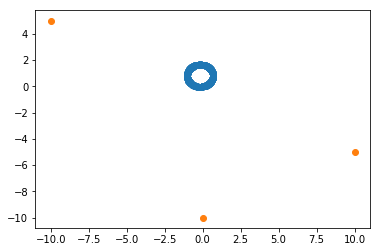

In [137]:
"""
Example of a crazy movement
"""

def scatter_positions(positions):
    xs = [p[0] for p in positions]
    ys = [p[1] for p in positions]
    plt.scatter(xs, ys)


vehicle = Vehicle(mass=2., position=np.array([0., 0.]), speed=0., direction=0.)
checkpoints=[
    CheckPoint(position=np.array([10., -5.]), radius=1.),
    CheckPoint(position=np.array([0., -10.]), radius=1.),
    CheckPoint(position=np.array([-10., 5.]), radius=1.)
]

track = Track(checkpoints=checkpoints, vehicle=vehicle, time_step=0.1)

positions = []
for action in [Action(turn=math.pi/2, thrust=1.)] * 300:
    positions.append(track.get_vehicle().position)
    track.move(action)

scatter_positions(positions)
scatter_positions([checkpoint.position for checkpoint in track.checkpoints])


# TODO - create a rather stupid agent that runs toward the target